### 3.5.4.2 结构学习

#### 1）基于得分（Score-based）的结构估计

* 得分函数（Scoring functions）

基于得分的方法是把结构学习问题作为一个优化问题来解决，而衡量模型和数据之间拟合度的常用得分函数有 BDeu 或 K2 等贝叶斯狄利克雷分数（Bayesian Dirichlet scores）和 BIC (也称为 MDL)等贝叶斯信息准则（ Bayesian Information Criterion）等。基于数据集对每个候选结构打分，得分高的结构为最优结构。下述案例生成了一个假的数据集，包含三个随机变量$(X,Y,Z)$，因为$Z=X+Y$，因此可知结构为$X \rightarrow Z \leftarrow Y$的 v-结构。为了验证`BDeu`、`K2`和`BIC`得分函数，假设模型`model1`符合 v-结构；而模型`model2`为$X \leftarrow Z \rightarrow Y$。从计算结果得知`model1`的各得分均高于`model2`，因此估计$X \rightarrow Z \leftarrow Y$为最优结构。

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.estimators import BDeuScore, K2Score, BicScore,ExhaustiveSearch,HillClimbSearch,PC,MmhcEstimator
from pgmpy.estimators.CITests import chi_square
from pgmpy.models import BayesianNetwork

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# create random data sample with 3 variables, where Z is dependent on X, Y:
data = pd.DataFrame(np.random.randint(0, 4, size=(5000, 2)), columns=list('XY'))
data['Z'] = data['X'] + data['Y']

bdeu = BDeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)

model1 = BayesianNetwork([('X', 'Z'), ('Y', 'Z')])  # X -> Z <- Y
model2 = BayesianNetwork([('X', 'Z'), ('X', 'Y')])  # Y <- X -> Z

print(f'model1:\nBDeuScore=\t{bdeu.score(model1)}\nK2Score=\t{k2.score(model1)}\nBicScore=\t{bic.score(model1)}')
print(f'model2:\nBDeuScore=\t{bdeu.score(model2)}\nK2Score=\t{k2.score(model2)}\nBicScore=\t{bic.score(model2)}')

model1:
BDeuScore=	-13938.698111661924
K2Score=	-14329.548959442178
BicScore=	-14294.73527862384
model2:
BDeuScore=	-20909.028603685794
K2Score=	-20935.843622693803
BicScore=	-20953.069518357206


分解分数，即给出待估计变量的潜在父变量情况下的得分。例如下述示例，给出了随机变量$Z$潜在不同父变量的得分，可知当父变量为$X,Y$时有最高得分。

In [ ]:
print(bdeu.local_score('Z', parents=[]))
print(bdeu.local_score('Z', parents=['X']))
print(bdeu.local_score('Z', parents=['X', 'Y']))

-9209.01947362572
-6991.892692505713
-57.120667260368634


* 结构搜索（Search strategies）

在随机变量的数量上，DAG 的搜索空间是超指数的（super-exponential）。对于少量变量节点的情况可以用穷举（完全）搜索`ExhaustiveSearch`返回得分最高的一个；对于含有大量节点的问题，如果使用穷举法，计算成本较高，因此通常使用启发式搜索策略（heuristic search strategies）估计最优结构。

对于只有3个变量的贝叶斯网络结构估计，使用穷举法总共估计有25个 DAGs，其中$X \rightarrow Z \leftarrow Y$的结构得分最高。

In [ ]:
es = ExhaustiveSearch(data, scoring_method=bic)
best_model = es.estimate()
print(len(list(es.all_dags())))
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, dag.edges())

25
[('X', 'Z'), ('Y', 'Z')]

All DAGs by score:
-14294.73527862384 [('X', 'Z'), ('Y', 'Z')]
-14330.662857922875 [('Y', 'X'), ('Z', 'X'), ('Z', 'Y')]
-14330.662857922875 [('X', 'Z'), ('Y', 'Z'), ('Y', 'X')]
-14330.662857922875 [('X', 'Y'), ('Z', 'X'), ('Z', 'Y')]
-14330.662857922875 [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')]
-14330.662857922875 [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
-14330.662857922876 [('Y', 'Z'), ('Y', 'X'), ('Z', 'X')]
-16511.124417627434 [('X', 'Y'), ('Z', 'Y')]
-16513.616802541135 [('Y', 'X'), ('Z', 'X')]
-18734.18799443991 [('Z', 'X'), ('Z', 'Y')]
-18734.18799443991 [('X', 'Z'), ('Z', 'Y')]
-18734.187994439915 [('Y', 'Z'), ('Z', 'X')]
-20914.64955414447 [('Z', 'Y')]
-20914.649554144475 [('Y', 'Z')]
-20917.141939058172 [('Z', 'X')]
-20917.141939058172 [('X', 'Z')]
-20950.577133443505 [('Y', 'X'), ('Z', 'Y')]
-20950.57713344351 [('X', 'Y'), ('Y', 'Z')]
-20950.577133443512 [('Y', 'Z'), ('Y', 'X')]
-20953.069518357206 [('X', 'Y'), ('Z', 'X')]
-20953.069518357206 [('X', 'Y'), 

如果包含较多的变量节点，则最好使用启发式搜索。例如生成有8个特征列的数据集，其中$A := B+C$，$H=G-A$，应用爬山算法（hill climbing）计算，从下述结果可以观察到$A,B,C$之间，$A,G,H$之间出现有向边，而其它随机变量不具有相关性，相互独立，节点之间无边连接。

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('A', 'H'), ('A', 'B'), ('A', 'C'), ('C', 'B'), ('G', 'H')]


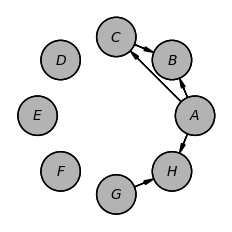

In [ ]:
# create some data with dependencies
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']

hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())
model_daft=best_model.to_daft()
model_daft.render(dpi=100);

#### 2）基于约束（Constrain-based）的结构估计

从数据集中构建 DAG 的一种非常直接的方式是：使用假设检验识别数据集中特征变量的独立性；根据确定的独立性构建 DAG。

* （有条件）独立性检验（（Conditional） Independence Tests）

数据集中特征变量的独立性测试可以使用 chi2 条件独立性测试`chi_square`方法识别。例如构建有$A := B+C$，$H=G-A,E \propto F$关系，下述判断结果满足上述关系，例如$B,H$之间并不独立，因为$B,H$之间存在一个节点$A$，使得$B,H$节点间存在有效迹，节点$B$的影响可以流动到节点$A$；但是如果给定节点$A$，则$B$和$H$之间独立。

In [ ]:
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

print(chi_square(X='B', Y='H', Z=[], data=data, significance_level=0.05))          # dependent
print(chi_square(X='B', Y='E', Z=[], data=data, significance_level=0.05))          # independent
print(chi_square(X='B', Y='H', Z=['A'], data=data, significance_level=0.05))       # independent
print(chi_square(X='A', Y='G', Z=[], data=data, significance_level=0.05))          # independent
print(chi_square(X='A', Y='G', Z=['H'], data=data, significance_level=0.05))       # dependent

False
True
False
True
False


* DAG（模式）构建（DAG (pattern) construction）

借助数据集中特征变量的独立性测试方法，可以分3步从数据集中构建 DAG：

1. 使用`build_skeleton`方法构建一个无向骨架（基本结构）（undirected skeleton）；
2. 使用`skeleton_to_pdag`方法定向强制的边获得部分有向无环图（partially directed acyclid graph，PDAG）（DAGs 的 I-等阶类（ I-equivalence class））；
3. 基于 PDAG，使用`to_dag`方法保守的定向剩余的边构建 DAG。

步骤1和2使用了称为 PC 的算法<sup>[Neapolitan, R. E. Learning Bayesian Networks. (Pearson Prentice Hall, 2004).]</sup>。

In [ ]:
est = PC(data)
skel, seperating_sets = est.build_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = pdag.to_dag()
print("DAG edges:        ", model.edges())

  0%|          | 0/5 [00:00<?, ?it/s]

Undirected edges:  [('A', 'B'), ('A', 'C'), ('A', 'H'), ('E', 'F'), ('G', 'H')]
PDAG edges:        [('G', 'H'), ('C', 'A'), ('A', 'H'), ('B', 'A'), ('F', 'E'), ('E', 'F')]
DAG edges:         [('G', 'H'), ('C', 'A'), ('A', 'H'), ('B', 'A'), ('F', 'E')]


`estimate`方法可以将上述3个步骤书写为一行代码。

In [ ]:
print(est.estimate(significance_level=0.01).edges())

  0%|          | 0/5 [00:00<?, ?it/s]

[('G', 'H'), ('C', 'A'), ('A', 'H'), ('B', 'A'), ('F', 'E')]


#### 3）混合（Hybrid）结构设计

MMHC（Max-Min Hill-Climbing）算法<sup>[Tsamardinos, I., Brown, L. E. & Aliferis, C. F. The max-min hill-climbing Bayesian network structure learning algorithm. Mach Learn 65, 31–78 (2006).]</sup>结合了基于约束和基于得分的方法，含有两个步骤：

1. 使用基于约束的结构估计从数据集中学习无向图的基本结构；
2. 使用基于得分的结构估计定向边。

In [ ]:
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']
data['E'] *= data['F']

mmhc = MmhcEstimator(data)
skeleton = mmhc.mmpc()
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(data)
model = hc.estimate(tabu_length=10, white_list=skeleton.to_directed().edges(), scoring_method=BDeuScore(data))
print("Part 2) Model:    ", model.edges())

Part 1) Skeleton:  [('A', 'C'), ('A', 'B'), ('A', 'H'), ('A', 'E'), ('A', 'F'), ('B', 'G'), ('C', 'H'), ('C', 'D'), ('C', 'F'), ('E', 'F'), ('E', 'G'), ('G', 'H')]


  0%|          | 0/1000000 [00:00<?, ?it/s]

Part 2) Model:     [('A', 'H'), ('B', 'A'), ('C', 'A'), ('F', 'E'), ('G', 'H')]


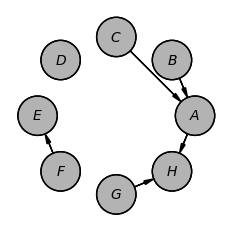

In [ ]:
model_daft=model.to_daft()
model_daft.render(dpi=100);

可以分步骤计算，也可以用`MmhcEstimator.estimate()`方法合并为一个步骤计算。

In [ ]:
data = pd.DataFrame(np.random.randint(0, 2, size=(2500, 4)), columns=list('XYZW'))
data['sum'] = data.sum(axis=1)
est = MmhcEstimator(data)
model = est.estimate()
print(model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('X', 'sum'), ('Y', 'sum'), ('Z', 'sum'), ('W', 'sum')]


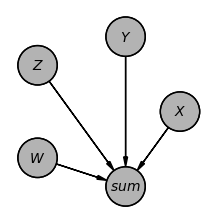

In [ ]:
model_daft=model.to_daft()
model_daft.render(dpi=100);

### 附：正定（半正定）(Positive (Semi)-Definite)协方差矩阵

协方差（covariance）表示特征向量之间的关系，正协方差表示特征值一起同向变化；负协方差表示特征反向变化。对于两个随机变量有$Cov(x, y) = E[x - \mu_x][y - \mu_y]^T $；对于一个随机向量有$Cov(x) = E[x - \mu][x - \mu]^T $，式中均值$\mu = \frac{1}{n}\sum_{i=1}^n x_i$；对于有$n$个观测值（样本）的$m$个随机特征向量，协方差矩阵为$Cov_{ij} = E[x_i - \mu_i][x_j - \mu_j] = \sigma_{ij},x_i \in \mathbb{R}^{m\times n}$。

为了方便观察和分类协方差矩阵的变化趋势关系，结合二阶函数几何形态的凹凸性分类有，

1. 如果一个矩阵是正定的（positive definite），它有一个绝对最小值，且在所有轴上都达到了最小值。如果一个$n \times n$对称矩阵（symmetric matrix）$M$是正定的，满足$x^TMx \gt 0 , x \in \mathbb{R}^{1 \times n}$；
2. 如果一个矩阵是半正定的（positive semi-definite），它至少在一个轴向量上有一个极小值。如果一个$n \times n$对称矩阵（symmetric matrix）$M$是半正定的，满足$x^TMx \geq 0,x \in \mathbb{R}^{n}$；
3. 如果一个矩阵是负定的（negative definite ），它有一个绝对最大值，且在所有轴上都达到了最大值；
4. 如果一个矩阵是半负定的（negative semi-definite），它至少在一个轴向量上有一个极大值；
5. 如果一个矩阵是无限的（indfinite），它有一个鞍点。

In [51]:
from datascience import *
from prob140 import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

In [68]:
%load_ext autoreload 
%autoreload 2 
import usda.data_visual as usda_vis
import usda.pgm as usda_pgm

* 正定的（positive definite）

In [72]:
def quadratic_form_positive_definite(x,y):
    return x**2+y**2

Plot_3d(x_limits=(-2,2), y_limits=(-2,2), f=quadratic_form_positive_definite, cstride=4, rstride=4,interactive=True)   

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

* 半正定的（positive semi-definite）

In [63]:
def quadratic_form_positive_semi_definite(x,y):
    return x**2

Plot_3d(x_limits=(-2,2), y_limits=(-2,2),f=quadratic_form_positive_semi_definite, cstride=4, rstride=4,interactive=True)   

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

* 负定的（negative definite ）

In [58]:
def quadratic_form_negative_definite(x,y):
    return -x**2-y**2

Plot_3d(x_limits=(-2,2), y_limits=(-2,2), f=quadratic_form_negative_definite, cstride=4, rstride=4,interactive=True)   

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

* 半负定的（negative semi-definite）

In [64]:
def quadratic_form_negative_semi_definite(x,y):
    return -x**2

Plot_3d(x_limits=(-2,2), y_limits=(-2,2),f=quadratic_form_negative_semi_definite, cstride=4, rstride=4,interactive=True) 

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

* 无限的（indfinite）

In [67]:
def quadratic_form_indefinite(x,y):
    return x**2-y**2

Plot_3d(x_limits=(-2,2), y_limits=(-2,2),f=quadratic_form_indefinite, cstride=4, rstride=4,interactive=True) 

interactive(children=(FloatSlider(value=20.0, description='elevation', max=90.0, step=1.0), FloatSlider(value=…

使用`covariance_test`方法判断协方差矩阵的类别，包括是否是正定、半正定的，是否为对称矩阵，是否为正行列式（Positive Determinant）及特征值（Eigen Values）是否为正。

In [73]:
cov=np.array([[4, 2, -2], 
              [2, 5, -5], 
              [-2, -5, 8]])
usda_pgm.covariance_test(cov,[0,1])

{'Positive Definite': True,
 'Positive Semi-Definite': True,
 'Symmetric': True,
 'Positive Determinant': True,
 'Eigen Values, Positivity': True}

概率图（probabilistic graphical model，PGM）是一种概率模型，其中图作为一个数据结构表示随机变量间的条件依赖关系和概率分布，在应用图论的知识解决概率论相关问题同时，且能够可视化随机变量的关系从而易于理解模型结构。概率图已经发展成熟，并广泛应用到各个领域，其中系统的经典论著有*Probabilistic Graphical Models : Principles and Techniques（概率图模型原理与技术）（2009）*<sup>[Koller D, Friedman N. Probabilistic Graphical Models : Principles and Techniques / Daphne Koller and Nir Friedman. MIT Press; 2009.]</sup>。为了避免概率图中繁琐的计算，使用 Python 解决 PGM 问题的库也得以发展，如下表：

| 序号  | Python 库  | 库的基本情况  | 备注  |
|---|---|---|---|
| 1  | [pgmpy](https://github.com/pgmpy/pgmpy)  | 持续更新，是；</br>使用者 $\geq $ 598人；</br>贡献者 $\geq $ 100人  | 专著，*Mastering Probabilistic Graphical Models Using Python : Master Probabilistic Graphical Models by Learning through Real-World Problems and Illustrative Code Examples in Python*<sup>[Ankan A, Panda A. Mastering Probabilistic Graphical Models Using Python : Master Probabilistic Graphical Models by Learning through Real-World Problems and Illustrative Code Examples in Python / Ankur Ankan, Abinash Panda. 1st edition. Packt Publishing; 2015.]</sup> ；</br>[在线手册](https://pgmpy.org/) |
| 2  | [pomegranate](https://github.com/jmschrei/pomegranate)  | 持续更新，是；</br>使用者 $\geq $ 891人；</br>贡献者 $\geq $ 64人 | [在线手册](https://github.com/jmschrei/pomegranate/tree/master/docs/tutorials)  |
| 3  | [PGM_PyLib](https://github.com/jona2510/PGM_PyLib)  | 持续更新，否 | 专著，*Probabilistic Graphical Models : Principles and Applications*<sup>[Sucar LE. Probabilistic Graphical Models : Principles and Applications / Luis Enrique Sucar. Second edition. Springer; 2021. doi:10.1007/978-3-030-61943-5]</sup>  |
| 4  | [PyGModels](https://github.com/D-K-E/graphical-models/)  | 持续更新，否  | [在线手册](https://d-k-e.github.io/graphical-models/html/index.html)  |
| 5  | [pyGMs](https://github.com/ihler/pyGMs)  |  持续更新，否  | /  |
| 6  | [pgmPy](https://github.com/indapa/pgmPy)  | 持续更新，否  | [课程](https://www.coursera.org/learn/probabilistic-graphical-models)  |
| 7  | [pgm](https://github.com/paulorauber/pgm)  | 持续更新，否  |   |


从上述 PGM 相关库的比较，目前仍在持续更新的有`pgmpy`和`pomegranate`两个库，且使用者和贡献者人数相对较多，具有在线手册或者已经出版的研究专著，因此在下述的 PGM 阐述上主要基于`pgmpy`实现，并参考 PGM 主要的论著及`pgmpy`库的手册进行解释。